# Error vs Load Latitude

## Imports

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pyslfp import FingerPrint, IceModel, plot
from joblib import Parallel, delayed
import pyshtools as pysh
import numpy as np

from Part_III_Project import sea_surface_height_change, create_ice_band

## Variable setting

In [44]:
lmax = 512

resolution = 50  # number of points from -90 to 90 degrees
load_radius = 10  # degrees
load_thickness_change = -100  # meters

satellite_range = np.round(np.linspace(1, 90, resolution), 2)
latitude = np.round(np.linspace(-90, 90, resolution), 2)

## Test

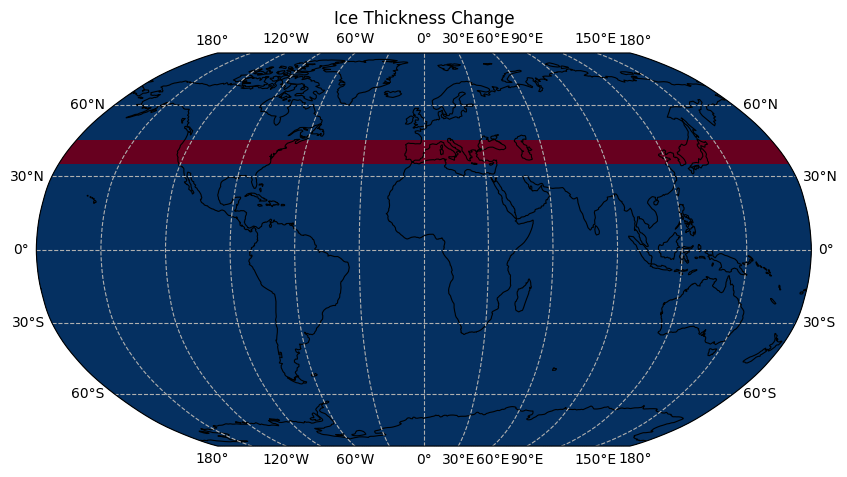

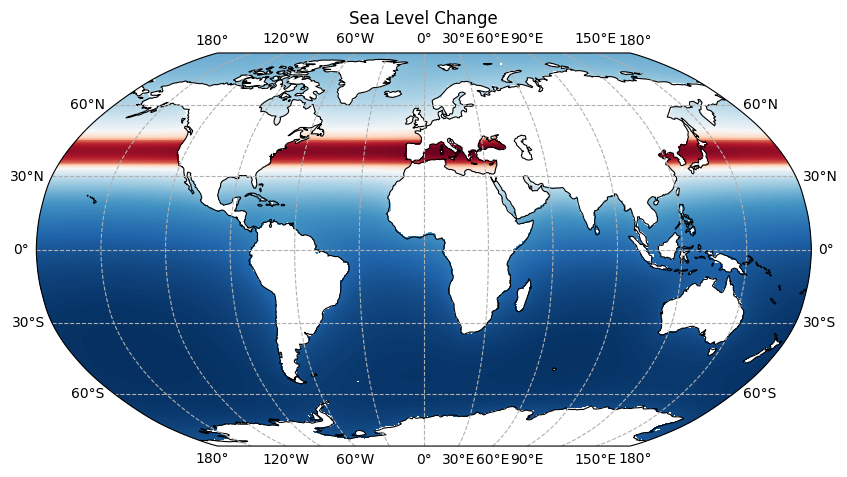

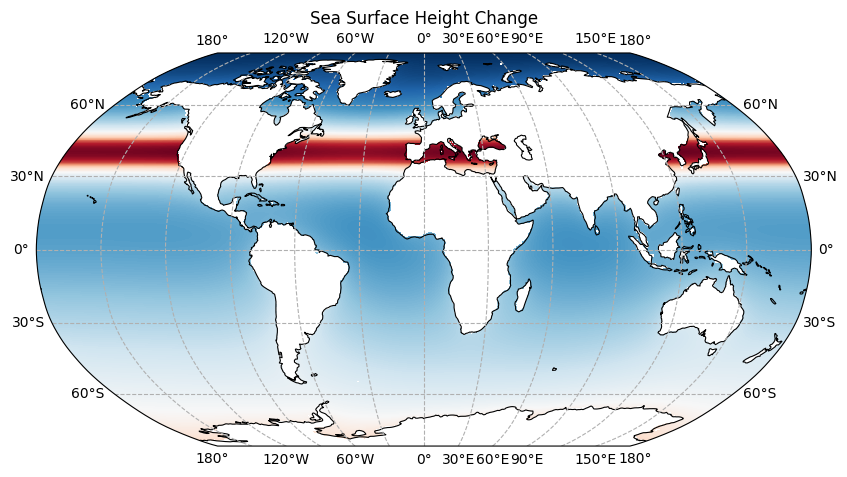

In [60]:
fp = FingerPrint(lmax=lmax)
fp.set_state_from_ice_ng()

ice_thickness_change = create_ice_band(
    lat_center=40,
    lat_width=5,
    ice_thickness=load_thickness_change,
    lmax=lmax,
)

(
    sea_level_change,
    displacement,
    gravity_potential_change,
    angular_velocity_change,
) = fp(direct_load=ice_thickness_change)

sea_surface_height_change_result = sea_surface_height_change(
    fp, sea_level_change, displacement, angular_velocity_change
)

# Create individual plots
fig1, ax1, im1 = plot(ice_thickness_change, coasts=True)
ax1.set_title("Ice Thickness Change")
plt.show()

fig2, ax2, im2 = plot(sea_level_change * fp.ocean_projection(), coasts=True)
ax2.set_title("Sea Level Change")
plt.show()

fig3, ax3, im3 = plot(
    sea_surface_height_change_result * fp.ocean_projection(), coasts=True
)
ax3.set_title("Sea Surface Height Change")
plt.show()

## Error calculation

In [45]:
error_output = pd.DataFrame(columns=["satellite_range", "latitude", "error"])

### Non-parallel version

In [5]:
fp = FingerPrint(lmax=lmax)
fp.set_state_from_ice_ng()

results = []

for load_lat in latitude:
    ice_thickness_change = create_ice_band(
        lat_center=load_lat,
        lat_width=load_radius,
        ice_thickness=load_thickness_change,
        lmax=lmax,
    )

    (
        sea_level_change,
        displacement,
        gravity_potential_change,
        angular_velocity_change,
    ) = fp(direct_load=ice_thickness_change)

    sea_surface_height_change_result = sea_surface_height_change(
        fp, sea_level_change, displacement, angular_velocity_change
    )

    mean_sea_level_change = fp.mean_sea_level_change(ice_thickness_change)
    for satellite_lat in satellite_range:
        altimetry_projection = fp.altimetry_projection(
            latitude_min=-satellite_lat, latitude_max=satellite_lat, value=0
        )

        altimetry_projection_integral = fp.integrate(altimetry_projection)
        altimetry_weighting_function = (
            altimetry_projection / altimetry_projection_integral
        )

        mean_sea_level_change_estimate = fp.integrate(
            altimetry_weighting_function * sea_surface_height_change_result
        )

        # Calculate relative error
        if np.abs(mean_sea_level_change) > 1e-10:
            error = (
                100
                * np.abs(mean_sea_level_change_estimate - mean_sea_level_change)
                / np.abs(mean_sea_level_change)
            )
        else:
            error = np.nan  # or 0, depending on how you want to handle this case

        results.append(
            {
                "satellite_range": satellite_lat,
                "latitude": load_lat,
                "error": error,
            }
        )
error_output = pd.DataFrame(results)

### Parallel version

In [46]:
def process_load_latitude(
    load_lat, satellite_range, load_radius, load_thickness_change, lmax
):
    """Process a single load latitude with all satellite ranges"""
    # Create a new FingerPrint instance for this process
    fp = FingerPrint(lmax=lmax)
    fp.set_state_from_ice_ng()

    ice_thickness_change = create_ice_band(
        lat_center=load_lat,
        lat_width=load_radius,
        ice_thickness=load_thickness_change,
        lmax=lmax,
    )

    (
        sea_level_change,
        displacement,
        gravity_potential_change,
        angular_velocity_change,
    ) = fp(direct_load=ice_thickness_change)

    sea_surface_height_change_result = sea_surface_height_change(
        fp, sea_level_change, displacement, angular_velocity_change
    )

    mean_sea_level_change = fp.mean_sea_level_change(ice_thickness_change)

    # Store results for this load_lat
    local_results = []

    for satellite_lat in satellite_range:
        altimetry_projection = fp.altimetry_projection(
            latitude_min=-satellite_lat, latitude_max=satellite_lat, value=0
        )

        altimetry_projection_integral = fp.integrate(altimetry_projection)
        altimetry_weighting_function = (
            altimetry_projection / altimetry_projection_integral
        )

        mean_sea_level_change_estimate = fp.integrate(
            altimetry_weighting_function * sea_surface_height_change_result
        )

        # Calculate relative error
        if np.abs(mean_sea_level_change) > 1e-10:
            error = (
                100
                * np.abs(mean_sea_level_change_estimate - mean_sea_level_change)
                / np.abs(mean_sea_level_change)
            )
        else:
            error = np.nan

        local_results.append(
            {
                "satellite_range": satellite_lat,
                "latitude": load_lat,
                "error": error,
            }
        )

    return local_results


# Parallel execution
results_nested = Parallel(n_jobs=-1, verbose=10)(
    delayed(process_load_latitude)(
        load_lat, satellite_range, load_radius, load_thickness_change, lmax
    )
    for load_lat in latitude
)

# Flatten the nested results
results = [item for sublist in results_nested for item in sublist]

error_output = pd.DataFrame(results)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done  33 out of  50 | elapsed:   40.7s remaining:   21.0s
[Parallel(n_jobs=-1)]: Done  33 out of  50 | elapsed:   40.7s remaining:   21.0s
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed:   51.3s remaining:   14.5s
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed:   51.3s remaining:   14.5s
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed:   52.5s remaining:    5.8s
[Parallel(n_jobs=-1)]:

In [29]:
print(error_output)
# export to csv
error_output.to_csv("load_lat_error_output.csv", index=False)

      satellite_range  latitude     error
0                1.00     -90.0  0.548185
1                2.82     -90.0  0.547669
2                4.63     -90.0  0.536265
3                6.45     -90.0  0.529227
4                8.27     -90.0  0.523347
...               ...       ...       ...
2495            82.73      90.0  3.799903
2496            84.55      90.0  4.486736
2497            86.37      90.0  5.487007
2498            88.18      90.0  6.214949
2499            90.00      90.0  6.495348

[2500 rows x 3 columns]


## Plotting results

Plotting as a heatmap of error vs load latitude and satellite coverage

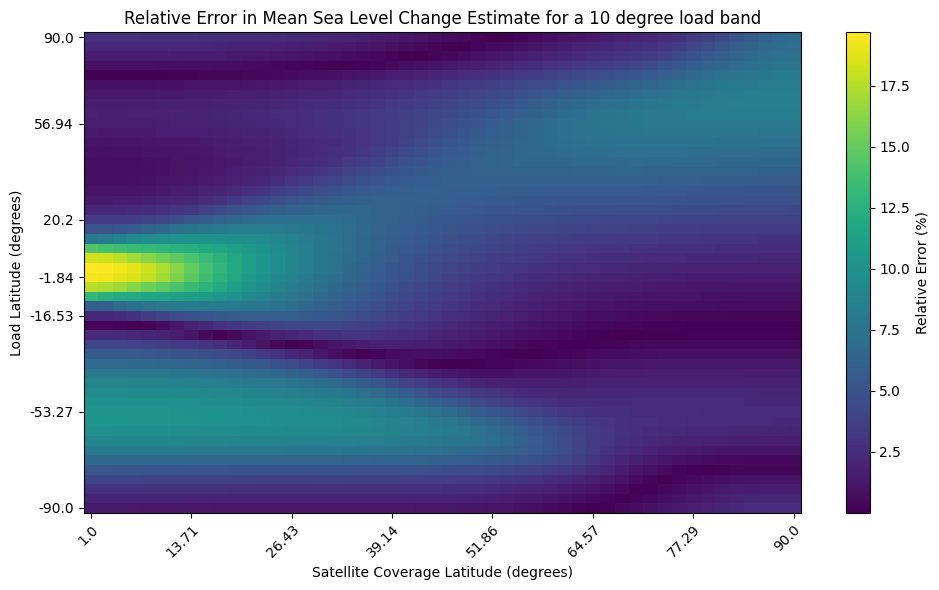

In [47]:
fig, ax = plt.subplots(figsize=(10, 6))
pivot_table = error_output.pivot(
    index="latitude", columns="satellite_range", values="error"
)
im = ax.imshow(
    pivot_table,
    aspect="auto",
    origin="lower",
    cmap="viridis",
)
plt.colorbar(im, label="Relative Error (%)")
ax.set_xlabel("Satellite Coverage Latitude (degrees)")
ax.set_ylabel("Load Latitude (degrees)")
ax.set_title(
    f"Relative Error in Mean Sea Level Change Estimate for a {load_radius} degree load band"
)

# Show all ticks and label them with the respective list entries
# Limit to max_ticks, but always include start, end, and for latitude: middle (0) NEEDS TO BE ODD NUMBER
max_ticks = 7

# X-axis ticks (satellite range): always include start and end, use max_ticks + 1
if len(satellite_range) <= max_ticks + 1:
    x_tick_indices = list(range(len(satellite_range)))
else:
    step = len(satellite_range) // max_ticks
    x_tick_indices = list(range(0, len(satellite_range), step))
    # Ensure last index is included
    if x_tick_indices[-1] != len(satellite_range) - 1:
        x_tick_indices.append(len(satellite_range) - 1)

# Y-axis ticks (latitude): always include start, end, and middle (0)
if len(latitude) <= max_ticks:
    y_tick_indices = list(range(len(latitude)))
else:
    # Find index closest to 0
    middle_idx = np.argmin(np.abs(latitude))
    step = len(latitude) // (max_ticks - 2)
    y_tick_indices = list(range(0, len(latitude), step))
    # Ensure middle (0) and last index are included
    if middle_idx not in y_tick_indices:
        y_tick_indices.append(middle_idx)
    if y_tick_indices[-1] != len(latitude) - 1:
        y_tick_indices.append(len(latitude) - 1)
    y_tick_indices = sorted(set(y_tick_indices))

ax.set_xticks(x_tick_indices)
ax.set_xticklabels(
    [satellite_range[i] for i in x_tick_indices],
    rotation=45,
    ha="right",
    rotation_mode="anchor",
)
ax.set_yticks(y_tick_indices)
ax.set_yticklabels([latitude[i] for i in y_tick_indices])

plt.tight_layout()
plt.show()